## Imports

In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import xgboost as xgb
import matplotlib.pyplot as plt

## Read & preprocess data

In [15]:
df = pd.read_csv(
    './Data/data-1666778624300.csv'
)

df.drop_duplicates(inplace=True, ignore_index=True)
df["debug"] = df["debug"].apply(lambda x : json.loads(x))
df = df.loc[df["debug"] != {}]

extra_cols = df["debug"][0].keys()
for col in extra_cols:
    values = [x[col] for x in df["debug"]]
    df[col] = values
df.drop("debug", axis="columns", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971 entries, 0 to 1098
Data columns (total 96 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    971 non-null    int64  
 1   uuid                                  971 non-null    object 
 2   url                                   971 non-null    object 
 3   filesource                            971 non-null    object 
 4   filestatus                            971 non-null    int64  
 5   filemimetype                          971 non-null    object 
 6   filename                              971 non-null    object 
 7   filehash                              971 non-null    object 
 8   filedate                              734 non-null    object 
 9   lastmodifieddate                      842 non-null    object 
 10  isfilepublished                       971 non-null    bool   
 11  wordcount         

In [16]:
len(df.loc[df["manual_classification"].notna()])

970

#### The following columns contain only null values and will not be used:

<ul>
    <li> 'issn'
    <li> 'usedpages'
    <li> 'depublicationdate'
    <li> 'document'
    <li> 'filepath'
    <li> 'institution_intervention_result'
    <li> 'institution_intervention_result_date'
    <li> 'publicationdate'
    <li> 'runidentifier'
</ul>


In [17]:
# for col in df.columns:
#     if df[col].isna().all():
#         print(col)
df.dropna(axis=1, how="all", inplace=True)

#### The following columns concern the predictions and will not be used as input:

<ul>
    <li> 'predictionmatrix'
    <li> 'prediction'
    <li> 'first_scan_result'
    <li> 'last_scan_result'
    <li> 'manual_classification'
</ul>

The column 'manual_classification' will be used as label, therefore all rows where this column has a null-value will be dropped. The other two columns will be dropped.

In [18]:
df.drop(['predictionmatrix', 'prediction', 'first_scan_result', 'last_scan_result'], axis="columns", inplace=True)
df.dropna(subset=['manual_classification'], inplace=True)

#### The following columns will not be used:

<ul>
    <li>'id' 
    <li>'uuid' 
    <li>'url' 
    <li>'filesource' 
    <li>'filename' 
    <li>'filehash' 
    <li>'filedate' 
    <li>'filemimetype' 
    <li>'lastmodifieddate'
    <li>'filescanresults' 
    <li>'doi'
    <li>'isbn' 
    <li>'author' 
    <li>'title' 
    <li>'publisher' 
    <li>'publicationyear'
    <li>'sourcepagecount' 
    <li>'sourcewordcount' 
    <li>'filetype' 
    <li>'userexcludedforscan'
    <li>'usedmultiplesources' 
    <li>'openaccesslink'
    <li>'apacitation' 
    <li>'contactcomment' 
    <li>'skippedcomment' 
    <li>'finaladvice'
    <li>'creator' 
    <li>'first_scan_result_date'
    <li>'human_intervention' 
    <li>'last_scan_result_date' 
    <li>'oclcnumber' 
    <li>'recordlastmodified' 
    <li>'rescan'
    <li>'course_id' 
    <li>'jstor' 
    <li>'always' 
    <li>'name'
    <li>'remarks'
    <li>'doc in metadata'
    <li>'ppt in metadata'
    <li>'file_ext_mp4_mov'
    <li>'file_ext_mp3_wav'
    <li>'Contains_sciencemag'
    <li>'Contains_researchgate'
    <li>'Contains_to_appear_in'
    <li>'Is_journal_words<8000'
    <li>'xls in metadata titel'
    <li>'Publisher_from_crossref'
    <li>'Contains_recommended_citation'
</ul>



In [44]:
skipped_cols = ['id', 'uuid', 'url', 'filesource',
'filename', 'filehash', 'filedate', 'filemimetype', 'lastmodifieddate',
'filescanresults', 'doi',
'isbn', 'author', 'title', 'publisher', 'publicationyear',
'sourcepagecount', 'sourcewordcount', 'filetype', 'userexcludedforscan',
'usedmultiplesources', 'openaccesslink',
'apacitation', 'contactcomment', 'skippedcomment', 'finaladvice',
'creator', 'first_scan_result_date',
'human_intervention', 'last_scan_result_date', 'oclcnumber', 'recordlastmodified', 'rescan',
'course_id', 'jstor', 'always', 'name', 'remarks', 'doc in metadata', 'ppt in metadata', 
'file_ext_mp4_mov', 'file_ext_mp3_wav', 'Contains_sciencemag', 'Contains_researchgate',
'Contains_to_appear_in', 'Is_journal_words<8000', 'xls in metadata titel',
'Publisher_from_crossref', 'Contains_recommended_citation']

df.drop(skipped_cols, axis='columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 0 to 1098
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   filestatus                        970 non-null    int64  
 1   isfilepublished                   970 non-null    bool   
 2   wordcount                         970 non-null    int64  
 3   pagecount                         970 non-null    int64  
 4   isopenaccesstitle                 970 non-null    bool   
 5   filesize                          970 non-null    float64
 6   incollection                      970 non-null    bool   
 7   openaccesscolor                   970 non-null    int64  
 8   picturecount                      970 non-null    int64  
 9   reliability                       970 non-null    int64  
 10  doi_in_oa                         970 non-null    object 
 11  manual_classification             970 non-null    object 
 12  DOI_in_

In [21]:
df["openaccesscolor"].fillna("nan", inplace=True)

encoder_openaccescolor = LabelEncoder()
encoder_openaccescolor.fit(df["openaccesscolor"])
df["openaccesscolor"] = df["openaccesscolor"].apply(lambda x : encoder_openaccescolor.transform([x])[0])

#### Fix dtype object

In [48]:
object_cols = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype == 'bool']
len(object_cols)

27

The code below creates a profiling report before we change the boolean feature, here we can see that False is the domininant class.

In [46]:
# import sys
# !{sys.executable} -m pip install -U pandas-profiling[notebook]
# !jupyter nbextension enable --py widgetsnbextension
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df.reset_index(drop=True), title="Pandas Profiling Report")
# profile.to_file("pandas_sql_report_bools_unchanged.html")

In [61]:
for col in object_cols:
    if set(df[col].dropna().unique()) == {False, True}:
        df.loc[df[col] == True, col] = 1
        df.loc[df[col] == False, col] = 0
        df[col] = df[col].fillna(0)
        df[col] = df[col].astype("int")
    if set(df[col].dropna().unique()) == {"False", "True"}:
        df.loc[df[col] == "True", col] = 1
        df.loc[df[col] == "False", col] = 0
        df[col] = df[col].fillna(0)
        df[col] = df[col].astype("int")
    if set(df[col].dropna().unique()) == {'"False"', '"True"'}:
        df.loc[df[col] == '"True"', col] = 1
        df.loc[df[col] == '"False"', col] = 0
        df[col] = df[col].fillna(0)
        df[col] = df[col].astype("int")
    elif len(set(df[col].dropna().unique())) == 1:
        df.drop(col, axis=1, inplace=True)

In [51]:
# import sys
# !{sys.executable} -m pip install -U pandas-profiling[notebook]
# !jupyter nbextension enable --py widgetsnbextension
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df.reset_index(drop=True), title="Pandas Profiling Report")
# profile.to_file("pandas_sql_report.html")

In [62]:
df.drop_duplicates(inplace=True, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   filestatus                        418 non-null    int64  
 1   isfilepublished                   418 non-null    int64  
 2   wordcount                         418 non-null    int64  
 3   pagecount                         418 non-null    int64  
 4   isopenaccesstitle                 418 non-null    int64  
 5   filesize                          418 non-null    float64
 6   incollection                      418 non-null    int64  
 7   openaccesscolor                   418 non-null    int64  
 8   picturecount                      418 non-null    int64  
 9   reliability                       418 non-null    int64  
 10  doi_in_oa                         418 non-null    int64  
 11  manual_classification             418 non-null    object 
 12  DOI_in_O

## Labels' support

Let's take a look at the support of each label, i.e., how often does each label occur in the dataset.

In [63]:
len(df)

418

In [64]:
labels = df["manual_classification"]
unique_labels = labels.unique()

for label in unique_labels:
    print('{:<32}  {:>3}'.format(label, (labels == label).sum()))

eigen materiaal - powerpoint       99
lange overname                     63
eigen materiaal - titelindicatie   28
eigen materiaal - overig           85
verwijderverzoek verstuurd         18
in onderzoek                       67
onbekend                            4
open access                        36
middellange overname               10
korte overname                      6
licentie beschikbaar                2


In [65]:
df.loc[df["manual_classification"] == "eigen materiaal - titelindicatie", "manual_classification"] = "eigen materiaal - overig"
df = df[df.manual_classification != "verwijderverzoek verstuurd"]
df = df[df.manual_classification != "in onderzoek"]
df = df[df.manual_classification != "onbekend"]
df = df[df.manual_classification != "licentie beschikbaar"]

labels = df["manual_classification"]
unique_labels = labels.unique()

for label in unique_labels:
    print('{:<32}  {:>3}'.format(label, (labels == label).sum()))

eigen materiaal - powerpoint       99
lange overname                     63
eigen materiaal - overig          113
open access                        36
middellange overname               10
korte overname                      6


## Prepare data

Split the data frame into x and encoded y, which we transform to numpy arrays. 

In [66]:
x = df.drop(["manual_classification"], axis="columns").to_numpy()

In [67]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["manual_classification"])

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [69]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## XGBoost model

There are many features with high correlation. XGBoost is not so sensitive to this. Another benefit of XGBoost is the ability to get feature importances quite easily.

#### Train using a simple data split

This makes is easy to use sklearn's classification report functionality, so we can very quickly evaluate how the model performs per class.

In [70]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train)

predictions = xgb_model.predict(x_test)
report = classification_report(y_test, predictions, target_names=label_encoder.classes_, labels=np.unique(y_train))
print(report)

                              precision    recall  f1-score   support

    eigen materiaal - overig       0.60      0.75      0.67        32
eigen materiaal - powerpoint       0.97      0.85      0.90        33
              korte overname       1.00      0.33      0.50         3
              lange overname       0.67      0.63      0.65        19
        middellange overname       0.00      0.00      0.00         3
                 open access       0.80      0.89      0.84         9

                    accuracy                           0.74        99
                   macro avg       0.67      0.58      0.59        99
                weighted avg       0.75      0.74      0.73        99



#### Confusion matrix

Let's take a look at a more detailed confusion matrix.

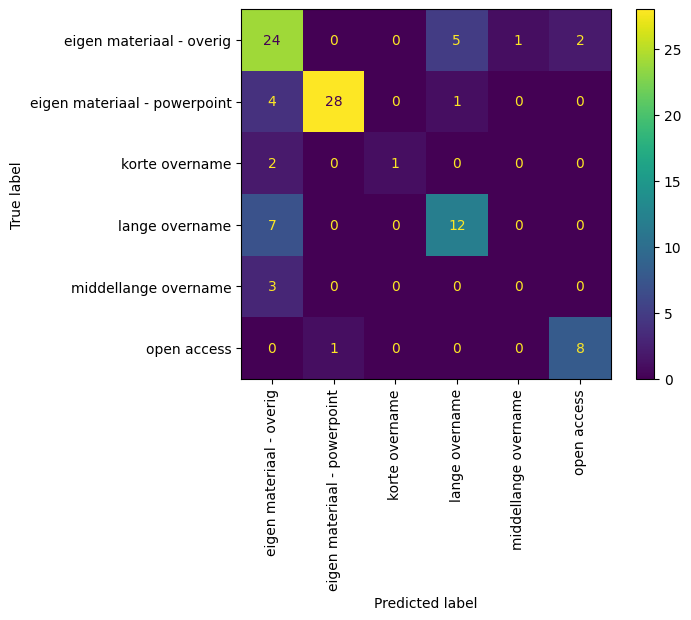

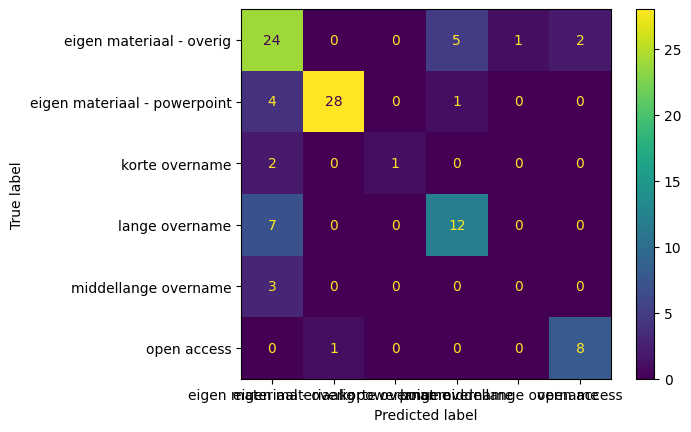

In [71]:
cm = confusion_matrix(y_test, predictions, labels=np.unique(y_train))
display = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=label_encoder.classes_, xticks_rotation="vertical")
display.plot()
plt.show()

#### Train using K-fold

This gives us a more reliable accuracy and F1-score, as we eliminate the risk of testing on a particularly favorable or unfavorable test partition.

(It is also useful for hyperparameter optimization, should we choose to add that in later.)

In [72]:
accuracy_scores = 0.0
f1_scores = 0.0

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(x_train, y_train)
    predictions = xgb_model.predict(x_test)
    accuracy_scores += accuracy_score(y_test, predictions)
    f1_scores += f1_score(y_test, predictions, average="macro")

print("Acc: ", accuracy_scores/5)
print("F1: ", f1_scores/5)

Acc:  0.7125407925407925
F1:  0.5836608798735584


#### Feature importances

In [75]:
xgb_model = xgb.XGBClassifier(max_depth=24)
# xgb_model = xgb.XGBClassifier()
xgb_model.fit(x, y)

feature_names = df.drop("manual_classification", axis="columns").columns.to_numpy()
feature_importance_scores = xgb_model.feature_importances_

top_five_indices = np.argpartition(feature_importance_scores, (-5, -1))[-5:]
top_five_scores = feature_importance_scores[top_five_indices][::-1]
top_five_names = feature_names[top_five_indices][::-1]

print("TOP FIVE\n---------------------------------")
for name, score in zip(top_five_names, top_five_scores):
    print('{:<18}  {:>3}'.format(name, score))


print("\n\n\nZERO SCORE\n---------------------------------")
zero_score_indices = np.argwhere(feature_importance_scores == 0).flatten()
zero_score_features = feature_names[zero_score_indices]

for feature in zero_score_features:
    print(feature)

TOP FIVE
---------------------------------
isopenaccesstitle   0.2582905888557434
images_same_pagecount  0.2322285771369934
openaccesscolor     0.09928276389837265
Words_more_300pp    0.06499868631362915
Contains_ISBN       0.048262324184179306



ZERO SCORE
---------------------------------
doi_in_oa
DOI_in_OA
DOI_no_PPT
ppt_creator
wordcount_o
10_pics_page
Contains_DOI
creator_abbyy
Creative commons
Kleiner_10_paginas
filename_indicator
Pagecount_bigger_50
book_and_words<10000
Contains_published_in
